In [ ]:
df = pd.DataFrame(rows[1:], columns=rows[0])
df.columns = ["Receipt_No", "Completion_Time", "Details", "Transaction_Status", "Paid_In", "Withdrawn", "Balance"]
df["Paid_In"] = pd.to_numeric(df["Paid_In"].str.replace(",", ""), errors='coerce').fillna(0)
df["Withdrawn"] = pd.to_numeric(df["Withdrawn"].str.replace(",", ""), errors='coerce').fillna(0)
df["Balance"] = pd.to_numeric(df["Balance"].str.replace(",", ""), errors='coerce').fillna(0)
df["Completion_Time"] = pd.to_datetime(df["Completion_Time"], errors='coerce')
df["Date"] = df["Completion_Time"].dt.date
df["Month"] = df["Completion_Time"].dt.to_period("M")
df["Year"] = df["Completion_Time"].dt.year
df["Day"] = df["Completion_Time"].dt.day
df["Hour"] = df["Completion_Time"].dt.hour
df["Minute"] = df["Completion_Time"].dt.minute
df["Second"] = df["Completion_Time"].dt.second
df["Transaction_Type"] = df["Details"].str.extract(r'([A-Za-z\s]+)')[0].str.strip()
df["Counterparty"] = df["Details"].str.extract(r'(?<=\s)([A-Za-z0-9\s]+)$')[0].str.strip()
df["Is_Credit"] = df["Paid_In"] > 0

In [38]:
file = "254714451214_2025-09-12_2025-01-01_1757699583410.pdf"

rows = []
with pdfplumber.open(file) as pdf:
    for page in pdf.pages:
        table = page.extract_table()
        if table:
            rows.extend(table)

In [45]:
df = pd.DataFrame(rows[1:], columns=rows[0])
df.columns = ["Receipt_No", "Completion_Time", "Details", "Transaction_Status", "Paid_In", "Withdrawn", "Balance"]
df["Paid_In"] = pd.to_numeric(df["Paid_In"].str.replace(",", ""), errors='coerce').fillna(0)
df["Withdrawn"] = pd.to_numeric(df["Withdrawn"].str.replace(",", ""), errors='coerce').fillna(0)
df["Balance"] = pd.to_numeric(df["Balance"].str.replace(",", ""), errors='coerce').fillna(0)
df["Completion_Time"] = pd.to_datetime(df["Completion_Time"], errors='coerce')
df["Date"] = df["Completion_Time"].dt.date
df["Month"] = df["Completion_Time"].dt.to_period("M")
df["Year"] = df["Completion_Time"].dt.year
df["Day"] = df["Completion_Time"].dt.day
df["Hour"] = df["Completion_Time"].dt.hour
df["Minute"] = df["Completion_Time"].dt.minute
df["Second"] = df["Completion_Time"].dt.second
df["Transaction_Type"] = df["Details"].str.extract(r'([A-Za-z\s]+)')[0].str.strip()
df["Counterparty"] = df["Details"].str.extract(r'(?<=\s)([A-Za-z0-9\s]+)$')[0].str.strip()
df["Is_Credit"] = df["Paid_In"] > 0     
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
print("Columns:", df.columns.tolist())
print(df.head())

Columns: ['Receipt_No', 'Completion_Time', 'Details', 'Transaction_Status', 'Paid_In', 'Withdrawn', 'Balance', 'Date', 'Month', 'Year', 'Day', 'Hour', 'Minute', 'Second', 'Transaction_Type', 'Counterparty', 'Is_Credit', 'Net_Amount', 'Cumulative_Balance', 'DayOfWeek', 'High_Value']
      Receipt_No     Completion_Time  \
5832  TA14M87W78 2025-01-01 17:23:31   
5831  TA16M87PK4 2025-01-01 17:23:38   
5829  TA17ME7JWX 2025-01-01 18:03:59   
5830  TA17ME7JWX 2025-01-01 18:03:59   
5828  TA17ME7JWX 2025-01-01 18:03:59   

                                                Details Transaction_Status  \
5832  Promotion Payment from\n3033815 - LOOP B2C. vi...          Completed   
5831     OD Loan Repayment to 232323 -\nM-PESA Overdraw          Completed   
5829  Customer Transfer Fuliza MPesa\nto - 07******1...          Completed   
5830                          OverDraft of Credit Party          Completed   
5828                 Customer Transfer of Funds\nCharge          Completed   

      P

In [46]:
df["Net_Amount"] = df["Paid_In"] - df["Withdrawn"]
df["Cumulative_Balance"] = df["Net_Amount"].cumsum()
df["Month"] = df["Completion_Time"].dt.to_period("M")
df["DayOfWeek"] = df["Completion_Time"].dt.day_name()
df["Hour"] = df["Completion_Time"].dt.hour
df = df.sort_values("Completion_Time")
df["High_Value"] = df[["Paid_In","Withdrawn"]].max(axis=1).apply(
    lambda x: "High-Value" if x >= 10000 else "Normal"
)

In [52]:
def categorize(details):
    if pd.isna(details): return "Other"
    details = details.lower()
    if "pay bill" in details: return "Bills"
    elif "buy goods" in details or "merchant" in details: return "Shopping"
    elif "funds received" in details or "business payment" in details: return "Income"
    elif "send money" in details or "transfer" in details: return "Personal Transfers"
    elif "loan" in details or "fuliza" in details: return "Loans & Fuliza"
    elif "savings" in details: return "Savings"
    else: return "Other"

df["Category"] = df["Details"].apply(categorize)


In [48]:
print("Total Money In:", df["Paid_In"].sum())
print("Total Money Out:", df["Withdrawn"].sum())
print("Net Flow:", df["Net_Amount"].sum())
print("Average Daily Spend:", df.groupby(df["Completion_Time"].dt.date)["Withdrawn"].sum().mean())
print("High-Value Transactions:", (df["High_Value"]=="High-Value").sum())


Total Money In: 866064.93
Total Money Out: -866064.93
Net Flow: 1732129.8599999999
Average Daily Spend: -3409.704448818897
High-Value Transactions: 12


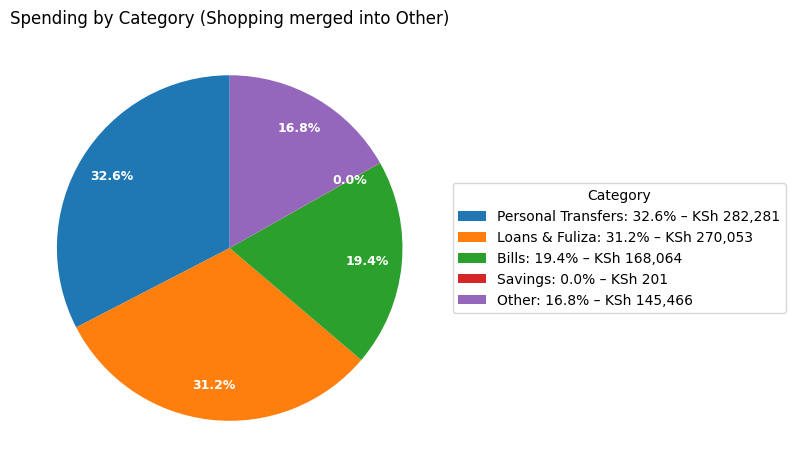

In [64]:
# assume `cat` is your Series: index=Category, values=withdrawn sums (absolute)
import pandas as pd
import matplotlib.pyplot as plt

# 1) Combine Shopping into Other
cat_comb = cat.copy()

# get shopping value (0 if not present)
shopping_val = cat_comb.get("Shopping", 0)

# drop Shopping if present, then add its value to Other (create Other if needed)
if "Shopping" in cat_comb.index:
    cat_comb = cat_comb.drop("Shopping")
    cat_comb["Other"] = cat_comb.get("Other", 0) + shopping_val

# 2) Sort descending but keep 'Other' at the end for clarity
if "Other" in cat_comb.index:
    non_other = cat_comb.drop("Other").sort_values(ascending=False)
    cat_final = pd.concat([non_other, pd.Series({"Other": cat_comb["Other"]})])
else:
    cat_final = cat_comb.sort_values(ascending=False)

# 3) Plot: % inside slices, legend shows "Name: X.X% – KSh value"
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    cat_final,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.8,
    textprops={"fontsize": 11}
)

total = cat_final.sum()
labels_with_values = [
    f"{name}: {value/total*100:.1f}% – KSh {value:,.0f}"
    for name, value in zip(cat_final.index, cat_final.values)
]

ax.legend(
    wedges,
    labels_with_values,
    title="Category",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

plt.setp(autotexts, size=9, weight="bold", color="white")
plt.title("Spending by Category (Shopping merged into Other)")
plt.tight_layout()
plt.show()


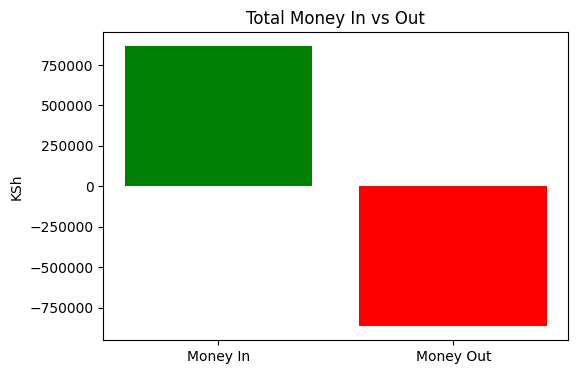

In [65]:
import matplotlib.pyplot as plt

totals = [df["Paid_In"].sum(), df["Withdrawn"].sum()]

plt.figure(figsize=(6,4))
plt.bar(["Money In", "Money Out"], totals, color=["green","red"])
plt.title("Total Money In vs Out")
plt.ylabel("KSh")
plt.show()

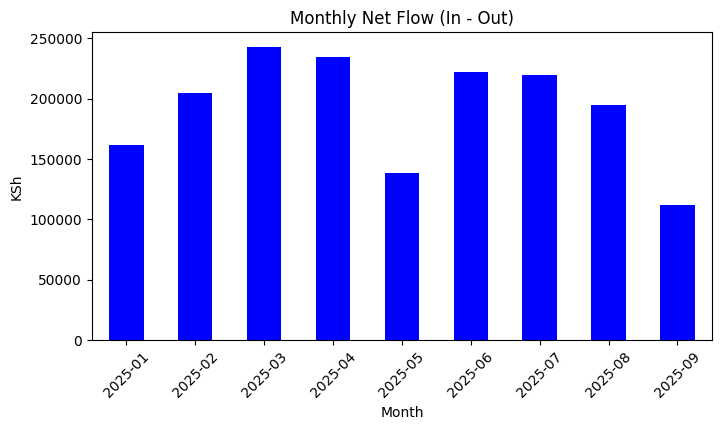

In [67]:
monthly = df.groupby("Month")["Net_Amount"].sum()

monthly.plot(kind="bar", figsize=(8,4), color="blue")
plt.title("Monthly Net Flow (In - Out)")
plt.ylabel("KSh")
plt.xticks(rotation=45)
plt.show()


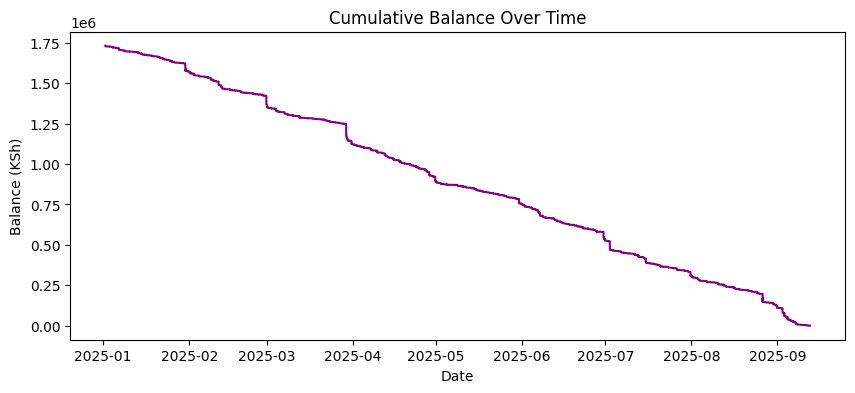

In [68]:
plt.figure(figsize=(10,4))
plt.plot(df["Completion_Time"], df["Cumulative_Balance"], color="purple")
plt.title("Cumulative Balance Over Time")
plt.xlabel("Date")
plt.ylabel("Balance (KSh)")
plt.show()


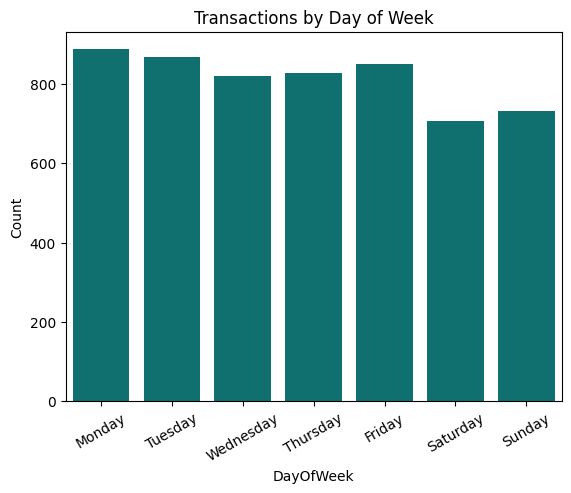

In [69]:
import seaborn as sns

freq = df.groupby("DayOfWeek")["Receipt_No"].count().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

sns.barplot(x=freq.index, y=freq.values, color="teal")
plt.title("Transactions by Day of Week")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


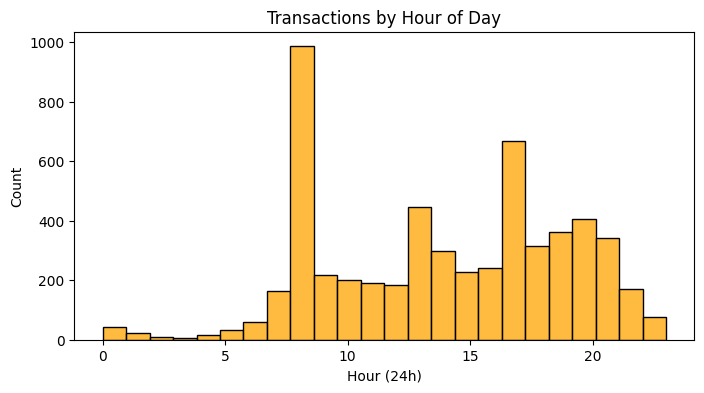

In [70]:
plt.figure(figsize=(8,4))
sns.histplot(df["Hour"], bins=24, kde=False, color="orange")
plt.title("Transactions by Hour of Day")
plt.xlabel("Hour (24h)")
plt.ylabel("Count")
plt.show()


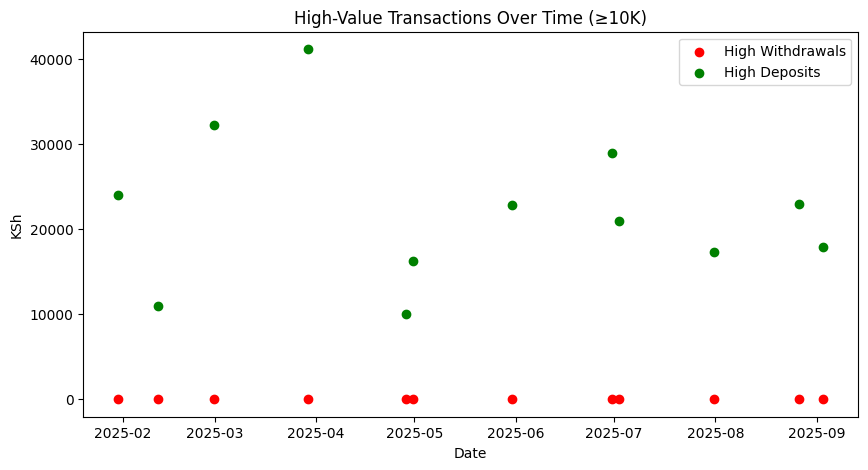

In [71]:
hv = df[df["High_Value"]=="High-Value"]

plt.figure(figsize=(10,5))
plt.scatter(hv["Completion_Time"], hv["Withdrawn"], color="red", label="High Withdrawals")
plt.scatter(hv["Completion_Time"], hv["Paid_In"], color="green", label="High Deposits")
plt.title("High-Value Transactions Over Time (≥10K)")
plt.xlabel("Date")
plt.ylabel("KSh")
plt.legend()
plt.show()
